<a href="https://colab.research.google.com/github/alvaphelan/Python-HowTos/blob/main/Curve_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fitting curves to data

Another extremely important aspect of this package is using curve_fit in order to fit lines and curves to data. This is useful when comparing theoretical and experimental values.

### How it works

First, you must import the curve fit function from scipy

In [ ]:
from scipy.optimize import curve_fit

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#creating x and y to work with
x = np.linspace(-50, 50, 40)
y = 6*x -4 

Then, you must define the function you want to fit to the data. In this example, we will go through a simple straight linear line but this can be done with quadratics, exponentials etc. 

In [ ]:
def func(x, m, c):
    y = m*x + c
    return y

Taking m as the slope and c as the intercept, this is the generic form for a straight line. 

Then, it is time to use curve_fit. This will provide you with two matruces, popt and pcov.

In [ ]:
popt, pcov = curve_fit(func, x, y)

Popt is an array with the optimum parameters for the function (m and c in this case), and they are in the same order as defined in the function. They can be accessed by the following (*as explained in section (link)*)

In [ ]:
m = popt[0]
c = popt[1]
print(f"The optimum slope for this function is {m} and intercept is {c}")

The optimum slope for this function is 6.0 and intercept is -3.999999999999995


Pcov returns the covariance matrix (explained in more detail here (link)), but simply the errors on the parameters are the square root of the diagonal elements of the matrix, in this case

In [ ]:
m_error = np.sqrt(pcov[0, 0])
c_error = np.sqrt(pcov[1, 1])


It is then possible to create a yfit to this function

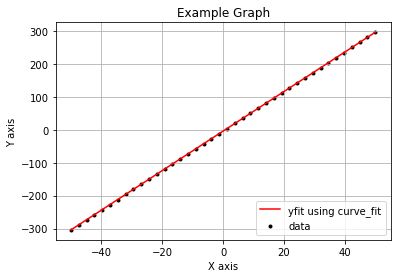

In [ ]:
yfit = popt[0]*x + popt[1]

#and can then graph the data and yfit
plt.scatter(x, y, marker = '.', color = 'black', label = 'data')
plt.plot(x, yfit, color = 'red', label = 'yfit using curve_fit')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('Example Graph')
plt.grid(True)
plt.legend(loc = 'lower right')